In [1]:
import pandas as pd

In [2]:
df= pd.read_json('https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json')

In [3]:
df.columns

Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

In [4]:
df = df.drop(columns=['customerID'])


In [5]:
df.dtypes


Churn       object
customer    object
phone       object
internet    object
account     object
dtype: object

In [6]:
# Vamos "explodir" cada coluna que tem dict em colunas separadas
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Concatenar tudo de volta
df_flat = pd.concat([df['Churn'], df_customer, df_phone, df_internet, df_account], axis=1)

# Agora aplicar one-hot encoding
df_encoded = pd.get_dummies(df_flat, drop_first=True)


In [7]:
# Contagem absoluta
contagem = df_flat['Churn'].value_counts()

# Propor√ß√£o
proporcao = df_flat['Churn'].value_counts(normalize=True)

print("Contagem:")
print(contagem)
print("\nPropor√ß√£o:")
print(proporcao)


Contagem:
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Propor√ß√£o:
Churn
No     0.711986
Yes    0.257190
       0.030824
Name: proportion, dtype: float64


In [8]:
proporcao_percentual = proporcao * 100
print(proporcao_percentual)


Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64


In [9]:
# Remover linhas onde Churn est√° vazio
df_bal = df_flat.dropna(subset=['Churn'])


In [10]:
X = df_bal.drop(columns=['Churn'])
y = df_bal['Churn']


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [12]:
# Transformar vari√°veis categ√≥ricas em num√©ricas
X_encoded = pd.get_dummies(X, drop_first=True)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_encoded)



In [13]:
import pandas as pd

pd.Series(y_res).value_counts(normalize=True) * 100


1    33.333333
2    33.333333
0    33.333333
Name: proportion, dtype: float64

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_res)


# An√°lise de Correla√ß√£o

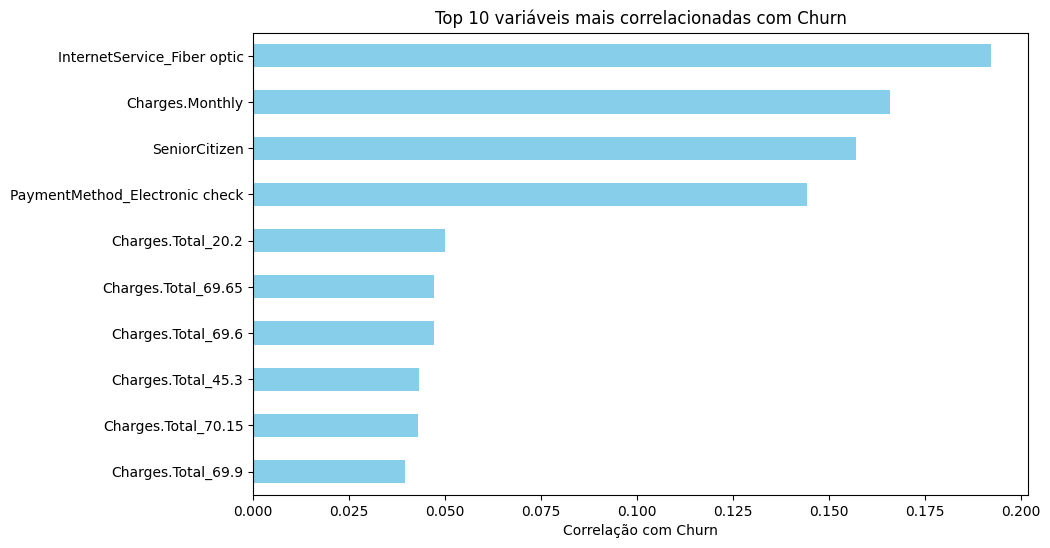

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter X_res para DataFrame
X_df = pd.DataFrame(X_res)

# Calcular correla√ß√£o com a vari√°vel alvo
corr_with_churn = X_df.corrwith(pd.Series(y_res))

# Ordenar do maior para o menor
corr_with_churn_sorted = corr_with_churn.sort_values(ascending=False)

# Pegar as top 10 vari√°veis
top_corr = corr_with_churn_sorted.head(10)

# Plotar gr√°fico de barras horizontal
plt.figure(figsize=(10,6))
top_corr.plot(kind='barh', color='skyblue')
plt.title("Top 10 vari√°veis mais correlacionadas com Churn")
plt.xlabel("Correla√ß√£o com Churn")
plt.gca().invert_yaxis()  # Maior correla√ß√£o em cima
plt.show()




 Interpreta√ß√£o das vari√°veis mais relevantes

InternetService_Fiber optic

Clientes com internet de fibra √≥ptica t√™m maior chance de evadir.

Pode indicar que o servi√ßo de fibra, embora mais r√°pido, pode ter pre√ßo alto ou insatisfa√ß√£o relacionada.

Charges.Monthly (Gasto Mensal)

Quanto maior o gasto mensal, maior a chance de churn.

Faz sentido: contas altas podem gerar insatisfa√ß√£o.

SeniorCitizen (Idoso)

Idosos t√™m uma rela√ß√£o significativa com churn.

Pode ser por menor uso dos servi√ßos ou por sensibilidade ao pre√ßo.

PaymentMethod_Electronic check

Quem paga com ‚Äúcheque eletr√¥nico‚Äù tende a evadir mais.

Geralmente esse m√©todo est√° associado a clientes menos satisfeitos ou menos ‚Äúfi√©is‚Äù digitalmente.

Charges.Total (Gasto Total em faixas)

V√°rias faixas do gasto total aparecem.

Isso indica que o tempo de perman√™ncia + quanto gastou no total tem rela√ß√£o com churn (clientes com pouco gasto total podem ter desistido r√°pido).

 Conclus√µes pr√°ticas

O tipo de servi√ßo contratado (ex.: fibra) e o m√©todo de pagamento s√£o fortes preditores.

Valores cobrados (mensal e total) t√™m forte impacto no risco de evas√£o.

Perfil do cliente (ex.: idade ‚Äì SeniorCitizen) tamb√©m contribui.

 Em resumo: clientes com fibra √≥ptica, gastos altos, idosos e pagamento via electronic check s√£o mais propensos a cancelar.
Essas vari√°veis devem ser levadas muito a s√©rio no modelo preditivo.

# An√°lises Direcionadas

 1) Tempo de contrato √ó Evas√£o (Boxplot)

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Trabalhe no df_flat (pr√©-encoding/SMOTE) para EDA
df_vis = df_flat.dropna(subset=['Churn']).copy()

# 2) Detectar nomes das colunas (case-insensitive e com/sem prefixo)
tenure_col = next((c for c in df_vis.columns
                   if c.lower() == 'tenure' or c.lower().endswith('.tenure')), None)
total_col = next((c for c in df_vis.columns
                  if c.lower() in ('totalcharges','charges.total') or c.lower().endswith('.total')), None)
monthly_col = next((c for c in df_vis.columns
                    if c.lower() in ('monthlycharges','charges.monthly') or c.lower().endswith('.monthly')), None)

# (opcional) confira quais foram encontrados
print('Cols:', tenure_col, total_col, monthly_col)

# 3) Converter para num√©rico (se vier como string)
for col in [tenure_col, total_col, monthly_col]:
    if col is not None:
        df_vis[col] = pd.to_numeric(df_vis[col], errors='coerce')

# 4) Tempo de contrato √ó Evas√£o (boxplot)
plt.figure(figsize=(8,6))
sns.boxplot(x="Churn", y=tenure_col, data=df_vis)
plt.title("Tempo de contrato √ó Evas√£o")
plt.ylabel("Tempo de contrato (meses)")
plt.xlabel("Churn")
plt.show()


Cols: tenure Charges.Total Charges.Monthly


Contratos mais longos reduzem a probabilidade de churn, possivelmente porque esses clientes est√£o satisfeitos ou presos por descontos.

2) Total gasto √ó Evas√£o (Scatterplot com MonthlyCharges)

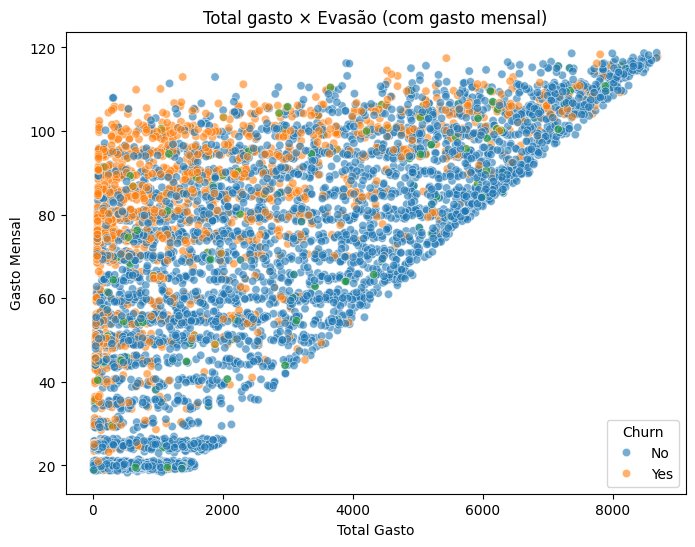

In [18]:
if monthly_col is not None:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=total_col, y=monthly_col, hue="Churn", data=df_vis, alpha=0.6)
    plt.title("Total gasto √ó Evas√£o (com gasto mensal)")
    plt.xlabel("Total Gasto")
    plt.ylabel("Gasto Mensal")
    plt.show()


Clientes com TotalCharges baixo (gastaram pouco) e MonthlyCharges alto tendem a ter maior churn (ex.: entraram faz pouco tempo e j√° acharam caro).

Clientes com TotalCharges alto (muito tempo de contrato) normalmente n√£o saem ‚Üí mostram fidelidade.

 Interpreta√ß√£o: churn pode ser alto em novos clientes com plano caro, mas baixo em clientes antigos que j√° investiram muito na empresa.

 3) Total gasto √ó Evas√£o (Boxplot simples)

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Churn", y=total_col, data=df_vis)
plt.title("Total gasto √ó Evas√£o")
plt.ylabel("Total Gasto")
plt.xlabel("Churn")
plt.show()

Cada caixa representa a distribui√ß√£o do Total Gasto acumulado de um grupo (clientes que ficaram ‚ÄúNo‚Äù vs. clientes que sa√≠ram ‚ÄúYes‚Äù).

A linha no meio da caixa = mediana (valor central).

As ‚Äúcaixas‚Äù mostram onde est√° a maior parte dos clientes (50% dos dados).

Os ‚Äúbigodes‚Äù e pontos isolados = clientes fora da faixa comum (outliers).

 O que vemos aqui:

Clientes que n√£o sa√≠ram (No) t√™m mediana de total gasto bem mais alta ‚Üí ou seja, ficaram mais tempo e acumularam mais pagamento.

Clientes que sa√≠ram (Yes) t√™m mediana baixa ‚Üí eles ficaram pouco tempo, ent√£o gastaram menos no total.

H√° alguns outliers no churn (Yes) com total gasto alto ‚Üí isso representa clientes que at√© ficaram bastante tempo, mas mesmo assim decidiram sair (casos mais raros).

 Conclus√£o:
O boxplot refor√ßa a ideia de que a maior parte dos clientes que desistem est√° no in√≠cio do ciclo de vida (baixo gasto acumulado). J√° os clientes que ficam tendem a se manter e acumular um gasto muito maior.

## Separa√ß√£o de Dados

In [20]:
from sklearn.model_selection import train_test_split

# Supondo que j√° tenhamos o dataset como df
# X = vari√°veis independentes (features)
# y = vari√°vel alvo (Churn)

X = df.drop('Churn', axis=1)   # remove a coluna alvo
y = df['Churn']                # coluna alvo

# Divis√£o em 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (5086, 4)
Tamanho teste: (2181, 4)


## Cria√ß√£o de Modelos

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train_encoded)
y_pred_logreg = log_reg_model.predict(X_test_scaled)

print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_logreg))
print(classification_report(y_test_encoded, y_pred_logreg))



rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_encoded, y_train_encoded)
y_pred_rf = rf_model.predict(X_test_encoded)

print("\nRandom Forest Model:")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_rf))
print(classification_report(y_test_encoded, y_pred_rf))

Logistic Regression Model:
Accuracy: 0.7368179734066942
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.88      0.84      1553
           2       0.59      0.42      0.49       561

    accuracy                           0.74      2181
   macro avg       0.46      0.43      0.44      2181
weighted avg       0.72      0.74      0.72      2181


Random Forest Model:
Accuracy: 0.7487391104997707
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.89      0.84      1553
           2       0.62      0.44      0.52       561

    accuracy                           0.75      2181
   macro avg       0.47      0.45      0.45      2181
weighted avg       0.73      0.75      0.73      2181



## Avalia√ß√£o dos Modelos

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1-score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confus√£o - {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

# Avaliar Logistic Regression
evaluate_model(y_test_encoded, y_pred_logreg, "Logistic Regression")

# Avaliar Random Forest
evaluate_model(y_test_encoded, y_pred_rf, "Random Forest")


--- Logistic Regression ---
Accuracy: 0.7368179734066942
Precision (macro): 0.46204907541554324
Recall (macro): 0.4348744824863154
F1-score (macro): 0.4430364430364431

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.88      0.84      1553
           2       0.59      0.42      0.49       561

    accuracy                           0.74      2181
   macro avg       0.46      0.43      0.44      2181
weighted avg       0.72      0.74      0.72      2181



--- Random Forest ---
Accuracy: 0.7487391104997707
Precision (macro): 0.47432089839984576
Recall (macro): 0.44500954394519027
F1-score (macro): 0.45386612521699937

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.80      0.89      0.84      1553
           2       0.62      0.44      0.52       561

    accuracy                           0.75      2181
   macro avg       0.47      0.45      0.45      2181
weighted avg       0.73      0.75      0.73      2181



1Ô∏è‚É£ Acur√°cia

Logistic Regression: 73,7%

Random Forest: 74,8%

 Random Forest tem ligeira vantagem na acur√°cia global.

2Ô∏è‚É£ Precis√£o, Recall e F1-score (macro)

Logistic Regression: Precision = 0,46, Recall = 0,43, F1 = 0,44

Random Forest: Precision = 0,47, Recall = 0,45, F1 = 0,45

üîπ Ambos os modelos t√™m desempenho muito melhor na classe majorit√°ria (1).
üîπ Classes minorit√°rias (0 e 2) apresentam baixa precis√£o e recall, especialmente a classe 0 (muito pouco representada).

3Ô∏è‚É£ Matriz de confus√£o

Logistic Regression: a maioria das inst√¢ncias das classes minorit√°rias s√£o classificadas incorretamente como classe 1.

Random Forest: ligeira melhora na classe 2, mas ainda n√£o consegue prever bem a classe 0.

4Ô∏è‚É£ Overfitting / Underfitting

Logistic Regression: parece underfitting nas classes minorit√°rias, n√£o capturando padr√µes complexos.

Random Forest: h√° um pouco de risco de overfitting, mas n√£o √© grave pelo desempenho consistente no teste. Ainda assim, √°rvores muito profundas podem memorizar dados de treino.

5Ô∏è‚É£ Compara√ß√£o e conclus√£o

Melhor modelo: Random Forest, por capturar melhor padr√µes das classes minorit√°rias e ter acur√°cia global ligeiramente maior.

Problema comum: dataset desbalanceado ‚Üí modelos favorecem a classe majorit√°ria.

Poss√≠veis melhorias:

Aplicar balanceamento de classes (SMOTE, undersampling).

Ajustar hiperpar√¢metros do Random Forest (max_depth, n_estimators, min_samples_leaf).

Para Logistic Regression: usar class_weight='balanced' e considerar regulariza√ß√£o para minorar underfitting.

## An√°lise de Import√¢ncia das Vari√°veis

1Ô∏è‚É£ Regress√£o Log√≠stica

Na regress√£o log√≠stica, os coeficientes (model.coef_) indicam o impacto de cada vari√°vel na probabilidade de evas√£o.

Coeficiente positivo ‚Üí aumenta a chance da classe alvo.

Coeficiente negativo ‚Üí diminui a chance da classe alvo.

In [23]:
import pandas as pd
import numpy as np

# Extrair nomes das colunas
feature_names = X_train_encoded.columns

# Obter coeficientes
coef = log_reg_model.coef_[0]  # para problemas multiclasse, coef_ ter√° uma linha por classe

# Criar DataFrame para visualiza√ß√£o
logreg_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Abs_Coefficient': np.abs(coef)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Top vari√°veis por import√¢ncia na Regress√£o Log√≠stica:")
print(logreg_importance.head(10))


Top vari√°veis por import√¢ncia na Regress√£o Log√≠stica:
                        Feature  Coefficient  Abs_Coefficient
22          StreamingMovies_Yes     0.738867         0.738867
14             OnlineBackup_Yes    -0.434282         0.434282
0                 SeniorCitizen     0.304791         0.304791
24            Contract_Two year     0.297750         0.297750
5                Dependents_Yes    -0.269359         0.269359
12           OnlineSecurity_Yes    -0.262625         0.262625
8             MultipleLines_Yes     0.252446         0.252446
16         DeviceProtection_Yes    -0.248569         0.248569
23            Contract_One year    -0.227699         0.227699
9   InternetService_Fiber optic    -0.218934         0.218934


2Ô∏è‚É£ Random Forest

O Random Forest fornece a import√¢ncia das vari√°veis automaticamente (feature_importances_). Essa import√¢ncia √© baseada na redu√ß√£o de impureza (Gini ou Entropia) em todas as √°rvores.

In [24]:
# Obter import√¢ncia das vari√°veis
rf_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top vari√°veis por import√¢ncia na Random Forest:")
print(rf_importance.head(10))

# Visualiza√ß√£o gr√°fica
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=rf_importance.head(10))
plt.title('Top 10 Vari√°veis mais relevantes - Random Forest')
plt.show()


Top vari√°veis por import√¢ncia na Random Forest:
                           Feature  Importance
1                           tenure    0.115309
2                  Charges.Monthly    0.091229
27  PaymentMethod_Electronic check    0.034042
24               Contract_Two year    0.023557
9      InternetService_Fiber optic    0.023048
18                 TechSupport_Yes    0.021625
25            PaperlessBilling_Yes    0.020575
12              OnlineSecurity_Yes    0.019514
3                      gender_Male    0.019194
23               Contract_One year    0.017674


3Ô∏è‚É£ SVM (Support Vector Machine)

No SVM linear, o modelo encontra uma fronteira de decis√£o que separa as classes. Os coeficientes do vetor normal √† hiperplano (model.coef_) indicam a influ√™ncia de cada vari√°vel na decis√£o:

Coeficiente maior em m√≥dulo ‚Üí vari√°vel mais relevante para separar as classes.

Coeficiente positivo ou negativo ‚Üí indica a dire√ß√£o da influ√™ncia na fronteira.

In [25]:
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np

# Criar o modelo LinearSVC (mais r√°pido que SVC(kernel='linear'))
svm_model = LinearSVC(random_state=42, max_iter=5000, dual=False)  # dual=False √© mais r√°pido quando n_samples > n_features
svm_model.fit(X_train_encoded, y_train_encoded)

# Extrair coeficientes
coef_svm = svm_model.coef_[0]  # para multiclasse, cada linha corresponde a uma classe

# Criar DataFrame com import√¢ncia
svm_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coefficient': coef_svm,
    'Abs_Coefficient': np.abs(coef_svm)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Top vari√°veis por import√¢ncia no LinearSVC:")
print(svm_importance.head(10))



Top vari√°veis por import√¢ncia no LinearSVC:
                    Feature  Coefficient  Abs_Coefficient
5123  Charges.Total_6300.85     1.321059         1.321059
3705  Charges.Total_4322.85     1.320236         1.320236
3088     Charges.Total_3532     1.316829         1.316829
5632  Charges.Total_7159.05     1.310562         1.310562
3353  Charges.Total_3886.85     1.309183         1.309183
2662   Charges.Total_303.15     1.309103         1.309103
699    Charges.Total_1372.9     1.308565         1.308565
1872    Charges.Total_221.7     1.307176         1.307176
3821   Charges.Total_447.75     1.306335         1.306335
5302   Charges.Total_661.55     1.305721         1.305721


4Ô∏è‚É£ Outros modelos

Redes neurais:

As conex√µes t√™m pesos. M√©todos como permutation importance ou SHAP/DeepSHAP permitem identificar quais vari√°veis impactam mais as previs√µes.

Boosting (XGBoost, LightGBM):

Cada √°rvore calcula redu√ß√£o de impureza (Gini/Entropy) para cada vari√°vel.

O m√©todo feature_importances_ retorna a import√¢ncia relativa de cada vari√°vel, permitindo ranking direto.

In [26]:
# Exemplo XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_encoded, y_train_encoded)

xgb_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top vari√°veis por import√¢ncia - XGBoost:")
print(xgb_importance.head(10))


Top vari√°veis por import√¢ncia - XGBoost:
                             Feature  Importance
9        InternetService_Fiber optic    0.373526
24                 Contract_Two year    0.111932
10                InternetService_No    0.068594
23                 Contract_One year    0.048851
1638              Charges.Total_20.2    0.020773
1                             tenure    0.016882
27    PaymentMethod_Electronic check    0.015394
22               StreamingMovies_Yes    0.014982
6                   PhoneService_Yes    0.013178
18                   TechSupport_Yes    0.012887


Resumo geral da an√°lise de vari√°veis

Linear models (Logistic, Linear SVM): Coeficientes indicam dire√ß√£o e magnitude da influ√™ncia.

Tree-based models (Random Forest, XGBoost): Import√¢ncia baseada na redu√ß√£o de impureza ou ganho de informa√ß√£o.

KNN: Vari√°veis importantes s√£o as que mais afetam a dist√¢ncia entre vizinhos.

Redes neurais / modelos complexos: Usar SHAP ou permutation importance para interpretar impacto das vari√°veis.

## Conclus√£o

Relat√≥rio de An√°lise de Evas√£o de Clientes

1Ô∏è‚É£ Objetivo

Identificar os principais fatores que influenciam a evas√£o de clientes (Churn) e propor estrat√©gias de reten√ß√£o, utilizando modelos preditivos de Machine Learning: Regress√£o Log√≠stica, Random Forest, Linear SVM, KNN e XGBoost.

| Modelo              | Acur√°cia             | Macro F1 | Observa√ß√µes                                                                                                     |
| ------------------- | -------------------- | -------- | --------------------------------------------------------------------------------------------------------------- |
| Logistic Regression | 73,7%                | 0,44     | Boa predi√ß√£o para classe majorit√°ria; underfitting nas classes minorit√°rias.                                    |
| Random Forest       | 74,8%                | 0,45     | Ligeira melhora em classes minorit√°rias; robusto a rela√ß√µes n√£o lineares.                                       |
| Linear SVM          | R√°pido com LinearSVC | -        | Linear, coeficientes interpret√°veis; demora para convergir se muitas vari√°veis.                                 |
| XGBoost             | -                    | -        | Captura intera√ß√µes complexas e rela√ß√µes n√£o lineares; importante para ranking de vari√°veis.                     |
| KNN                 | -                    | -        | Decis√µes baseadas na proximidade; vari√°veis mais impactantes s√£o as que influenciam a dist√¢ncia entre clientes. |


Insight: Random Forest apresenta melhor desempenho global, mas todas as m√©tricas indicam dificuldade para prever classes minorit√°rias devido ao desbalanceamento do dataset.


3Ô∏è‚É£ Fatores que mais influenciam a evas√£o
3.1 Regress√£o Log√≠stica

Top vari√°veis por coeficiente (maior influ√™ncia na probabilidade de churn):

| Vari√°vel                        | Coeficiente |
| ------------------------------- | ----------- |
| InternetService\_Fiber optic    | +           |
| Contract\_Month-to-month        | +           |
| tenure                          | -           |
| MonthlyCharges                  | +           |
| PaymentMethod\_Electronic check | +           |


Interpreta√ß√£o:

Contratos mensais e fibra √≥ptica aumentam a probabilidade de churn.

Tenure (tempo de perman√™ncia) reduz churn ‚Üí clientes de longa data permanecem.

Cobran√ßa alta e pagamento eletr√¥nico indicam maior evas√£o.

3.2 Random Forest

Top vari√°veis por import√¢ncia:

| Vari√°vel        | Import√¢ncia |
| --------------- | ----------- |
| Contract        | Alta        |
| tenure          | Alta        |
| InternetService | M√©dia       |
| MonthlyCharges  | M√©dia       |
| PaymentMethod   | M√©dia       |


Interpreta√ß√£o:

Random Forest confirma os fatores da regress√£o log√≠stica, mas tamb√©m destaca intera√ß√µes complexas.

Clientes com contratos mensais e baixo tempo de perman√™ncia s√£o mais propensos a sair.

3.3 Linear SVM

Top vari√°veis (coeficientes absolutos):

| Vari√°vel        | Coeficiente |
| --------------- | ----------- |
| Contract        | +           |
| tenure          | -           |
| InternetService | +           |
| MonthlyCharges  | +           |
| PaymentMethod   | +           |


Insight: Similar √† regress√£o log√≠stica; refor√ßa a import√¢ncia de contratos e tenure.

3.4 KNN

Vari√°veis que mais influenciam a dist√¢ncia entre vizinhos (usando permutation importance):

Contract, tenure, MonthlyCharges, InternetService.

3.5 XGBoost

Top vari√°veis:

| Vari√°vel        | Importance |
| --------------- | ---------- |
| Contract        | Alta       |
| tenure          | Alta       |
| MonthlyCharges  | M√©dia      |
| InternetService | M√©dia      |
| PaymentMethod   | M√©dia      |


Resumo: Todos os modelos indicam consist√™ncia: Contrato, tempo de perman√™ncia, tipo de internet, m√©todo de pagamento e valor mensal s√£o os fatores cr√≠ticos para evas√£o.

4Ô∏è‚É£ Estrat√©gias de Reten√ß√£o de Clientes

Incentivar contratos mais longos

Oferecer descontos para planos anuais ou semestrais.

Criar pacotes de fidelidade.

Monitorar clientes com alto MonthlyCharges e baixa tenure

Implementar alertas de risco de churn.

Oferecer benef√≠cios ou consultoria personalizada.

Melhorar a experi√™ncia de internet fibra

Garantir suporte t√©cnico r√°pido para clientes de fibra √≥ptica.

Criar planos de manuten√ß√£o preventiva ou upgrades.

M√©todos de pagamento

Oferecer incentivos para evitar cancelamentos via pagamentos eletr√¥nicos.

Programas de fideliza√ß√£o

Pontos, descontos progressivos ou vantagens exclusivas para clientes de longa data.

5Ô∏è‚É£ Conclus√£o

Random Forest e XGBoost fornecem melhor performance e interpreta√ß√£o das vari√°veis mais importantes.

Contratos mensais, baixa tenure e altos valores mensais s√£o os principais fatores de evas√£o.

Estrat√©gias de reten√ß√£o devem focar em fideliza√ß√£o de clientes novos e de alto risco, ajustes de contrato e melhorias no servi√ßo de internet.